this file contains all the algorithms together in one file


We start with our baseline model, KNN.
We implemented the KNN on our own without using the one from sklearn

Model :

In [1]:
import math
import cv2
import dlib
import time
from collections import Counter
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
import seaborn as sns

import data_process


class ModelKNN:
    def __init__(self, train_x, train_y):
        self.training_x = train_x
        self.training_t = train_y
        self.emotion_data = self.initial_data()

    def initial_data(self):
        data = {'pixels': [], 'emotion': ''}
        t = pd.DataFrame(data=data)
        return t

    def detect_face(self, img_path):
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        emotions = ['anger', 'contempt', 'happy', 'sadness']
        faceDet = cv2.CascadeClassifier("haarcascade\haarcascade_frontalface_default.xml")
        if img_path == 'video':
            cap = cv2.VideoCapture(0)
            while True:
                k = cv2.waitKey(1)
                ret, img = cap.read()
                # img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                # img = cv2.flip(img, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = faceDet.detectMultiScale(
                    gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(20, 20)
                )
                for (x, y, w, h) in faces:
                    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    gray = gray[y:y + h, x:x + w]
                    # get_landmarks(img)

                cv2.imshow('video', img)

                if k == 32:
                    try:
                        gray = cv2.resize(gray, (350, 350))
                        print(self.predict(gray, 5))
                    except:
                        print('error')
                if k == 27:
                    break
            cap.release()
            cv2.destroyAllWindows()
            return 'close'

        else:
                frame = cv2.imread(img_path)

                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                face = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5),
                                                flags=cv2.CASCADE_SCALE_IMAGE)
                if len(face) == 1:
                    facefeatures = face
                else:
                    facefeatures = ""

                for (x, y, w, h) in facefeatures:
                    if facefeatures == "":
                        print("no face found in file: %s" % img_path)
                    else:
                        gray = gray[y:y + h, x:x + w]

                detections = detector(gray, 1)
                for k, d in enumerate(detections):
                    shape = predictor(gray, d)
                    for i in range(1, 68):
                        cv2.circle(gray, (shape.part(i).x, shape.part(i).y), 1, (0, 0, 255), thickness=1)
                gray = cv2.resize(gray, (48, 48))
                cv2.imwrite(img_path, gray)


    def train(self, t_data, label):
        for f, b in zip(t_data, label):
            try:
                self.emotion_data.loc[-1] = [f, b]
                self.emotion_data.index = self.emotion_data.index + 1
                self.emotion_data = self.emotion_data.sort_index()
            except:
                print('error in "' + b)

    def euclidean_distance(self, row1, row2):
        distance_x = 0.0
        distance_x += (row1 - row2)**2
        return sum(sum(sum(np.sqrt(distance_x))))


    def predict(self, face, k):
        distance_d = {'distance': [], 'emotion': ''}
        df = pd.DataFrame(data=distance_d)
        for i, r in self.emotion_data.iterrows():
            distance = self.euclidean_distance(self.emotion_data.iloc[i]['pixels'], face)
            df.loc[-1] = [distance, self.emotion_data.iloc[i]['emotion']]
            df.index = df.index + 1
            df = df.sort_index()
        df2 = df.sort_values(by=['distance'], ascending=True, axis=0)[:k]
        counter = Counter(df2['emotion'])
        prediction = counter.most_common()[0][0]
        return prediction


    def test(self, p_data, label):
        start_time = time.time()
        correct = 0
        incorrect = 0
        for f, b in zip(p_data, label):
            predict_face = self.predict(f, 5)
            if b == predict_face:
                correct += 1
            else:
                incorrect += 1
        accuracy = (1 / (correct + incorrect)) * correct
        print('correct: ' + str(correct) + '\n' + 'incorrect: ' + str(incorrect) + '\n' + 'accuracy: ' + str(accuracy) + '\n' + "--- %s seconds ---" % (time.time() - start_time))

get training data and test data from dataset 1:

In [2]:
xKNN,yKNN = data_process.process_data('dataset.csv', "KNN")
X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split(xKNN, yKNN, test_size=0.2, random_state=42)

x2KNN,y2KNN = data_process.process_data('dataset2.csv', "KNN")
X_train2KNN, X_test2KNN, y_train2KNN, y_test2KNN = train_test_split(x2KNN, y2KNN, test_size=0.2, random_state=42)

x, y = data_process.process_data('dataset.csv', "OTHER")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x2, y2 = data_process.process_data('dataset2.csv', "OTHER")
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)

xCNN, yCNN, a = data_process.process_data('dataset.csv', "CNN")
X_trainCNN, X_testCNN, y_trainCNN, y_testCNN = train_test_split(xCNN, yCNN, test_size=0.2, random_state=42)
val_data = (X_testCNN,y_testCNN)

x2CNN, y2CNN, a2 = data_process.process_data('dataset2.csv', "CNN")
X_train2CNN, X_test2CNN, y_train2CNN, y_test2CNN = train_test_split(x2CNN, y2CNN, test_size=0.2, random_state=42)
val_data2 = (X_test2CNN,y_test2CNN)

create model and train it with training data, test it afterwards.

In [3]:
%%time
model_1 = ModelKNN(X_trainKNN, y_trainKNN)
model_1.train(X_trainKNN, y_trainKNN)
model_1.test(X_testKNN,y_testKNN)

correct: 64
incorrect: 32
accuracy: 0.6666666666666666
--- 71.30238580703735 seconds ---
Wall time: 1min 11s


as we can see, the testing duration is very long


again very long testing duration
train and test it again

In [4]:
%%time
model_2 = ModelKNN(X_train2KNN, y_train2KNN)
model_2.train(X_train2KNN, y_train2KNN)
model_2.test(X_test2KNN,y_test2KNN)

correct: 66
incorrect: 30
accuracy: 0.6875
--- 70.68956637382507 seconds ---
Wall time: 1min 11s


metrics for both models

In [5]:
from sklearn.metrics import precision_recall_fscore_support as score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

metricsKNN = list()
cmKNN = dict()

y_predKNN = list()
y_pred2KNN = list()
for a in X_testKNN:
    y_predKNN.append(model_1.predict(a,5))

for a in X_test2KNN:
      y_pred2KNN.append(model_2.predict(a,5))


In [6]:
from sklearn.preprocessing import LabelEncoder, label_binarize

enc = LabelEncoder()
y_testKNN = enc.fit_transform(y_testKNN)
y_predKNN = enc.fit_transform(y_predKNN)

y_test2KNN = enc.fit_transform(y_test2KNN)
y_pred2KNN = enc.fit_transform(y_pred2KNN)

precision, recall, fscore, _ = score(y_testKNN, y_predKNN, average='weighted')
accuracy = accuracy_score(y_testKNN, y_predKNN)
auc = roc_auc_score(label_binarize(y_testKNN, classes=[0,1,2]),
        label_binarize(y_predKNN, classes=[0,1,2]),
        average='weighted', multi_class='ovr')
metricsKNN.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'AUC':auc}, name="model1 KNN"))
cmKNN = confusion_matrix(y_testKNN,y_predKNN)

metrics2KNN = list()
cm2KNN = dict()

precision2, recall2, fscore2, _ = score(y_test2KNN, y_pred2KNN, average='weighted')
accuracy2 = accuracy_score(y_test2KNN, y_pred2KNN)
auc2 = roc_auc_score(label_binarize(y_test2KNN, classes=[0,1,2]),
        label_binarize(y_pred2KNN, classes=[0,1,2]),
        average='weighted', multi_class='ovr')
metrics2KNN.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2,'AUC':auc2}, name="model2 KNN"))
cm2KNN = confusion_matrix(y_test2KNN,y_pred2KNN)
m = metricsKNN + metrics2KNN
metricsKNN = pd.concat(m, axis=1)

metricsKNN

,model1 KNN,model2 KNN
precision,0.678905,0.704633
recall,0.666667,0.687500
fscore,0.671121,0.691660
accuracy,0.666667,0.687500
AUC,0.787383,0.793750


[2, 0, 3, 1]


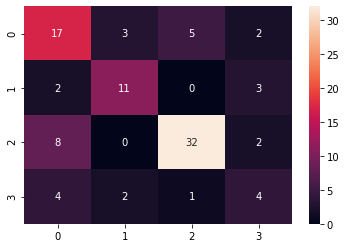

In [7]:
%matplotlib inline

def get_unique_N(iterable):
    seen = set()
    for e in iterable:
        if e in seen:
            continue
        seen.add(e)
        yield e

k = get_unique_N(y_testKNN)
print(list(k))

ax = sns.heatmap(cmKNN, annot=True, fmt='d')



[2, 0, 3, 1]


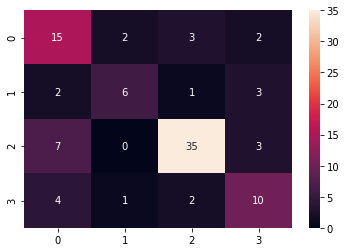

In [8]:
k = get_unique_N(y_test2KNN)
print(list(k))
ax2 = sns.heatmap(cm2KNN, annot=True, fmt='d')

next up we will do the random forest algorithm

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import data_process

In [10]:
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import pydotplus

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
data = tree.export_graphviz(dtree)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('mydecisiontree.png')

True

In [11]:
y_predTREE = dtree.predict(X_test)

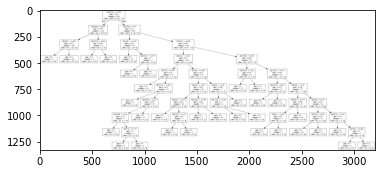

In [12]:
img=pltimg.imread('mydecisiontree.png')
imgplot = plt.imshow(img)
plt.show()



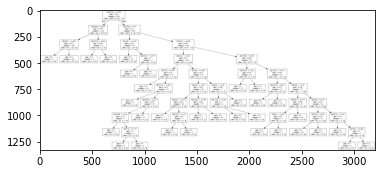

In [13]:
dtree2 = DecisionTreeClassifier()
dtree2 = dtree2.fit(X_train2, y_train2)
data2 = tree.export_graphviz(dtree2)
graph2 = pydotplus.graph_from_dot_data(data2)
graph2.write_png('mydecisiontree2.png')
y_pred2TREE = dtree2.predict(X_test2)
img2=pltimg.imread('mydecisiontree2.png')
imgplot = plt.imshow(img)
plt.show()

In [14]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


metrics = list()
cm = dict()

y_test_trueTREE = y_test
y_test_true2TREE = y_test2

enc = LabelEncoder()
y_testTREE = enc.fit_transform(y_test)
y_predTREE = enc.fit_transform(y_predTREE)

y_test2TREE = enc.fit_transform(y_test2)
y_pred2TREE = enc.fit_transform(y_pred2TREE)

precision, recall, fscore, _ = score(y_testTREE, y_predTREE, average='weighted')
accuracy = accuracy_score(y_testTREE, y_predTREE)
auc = roc_auc_score(label_binarize(y_testTREE, classes=[0,1,2]),
        label_binarize(y_predTREE, classes=[0,1,2]),
        average='weighted', multi_class='ovr')
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'AUC':auc}, name="random forest 1"))
cm = confusion_matrix(y_testTREE,y_predTREE)

metrics2 = list()
cm2 = dict()

precision2, recall2, fscore2, _ = score(y_test2TREE, y_pred2TREE, average='weighted')
accuracy2 = accuracy_score(y_test2TREE, y_pred2TREE)
auc2 = roc_auc_score(label_binarize(y_test2TREE, classes=[0,1,2]),
        label_binarize(y_pred2TREE, classes=[0,1,2]),
        average='weighted', multi_class='ovr')
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2,'AUC':auc2}, name="Random forest 2"))
cm2 = confusion_matrix(y_test2TREE,y_pred2TREE)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics

,random forest 1,Random forest 2
precision,0.703463,0.912253
recall,0.708333,0.906250
fscore,0.704456,0.907340
accuracy,0.708333,0.906250
AUC,0.803967,0.955476


In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

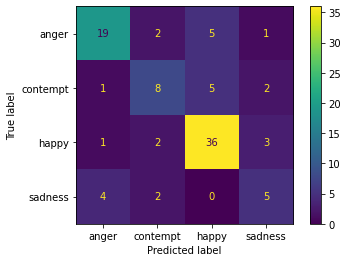

In [16]:
plot_confusion_matrix(dtree, X_test, y_test_trueTREE)



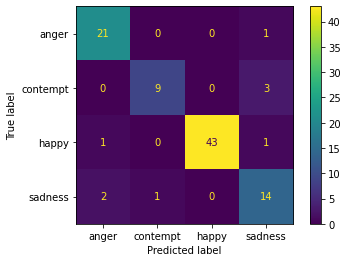

In [17]:
plot_confusion_matrix(dtree2, X_test2, y_test_true2TREE)

next we will do SGD

In [18]:
SDGclass = SGDClassifier(loss='log', alpha=0.1, penalty='l2')

In [19]:
SDGclass = SDGclass.fit(X_train, y_train)
y_predSGD = SDGclass.predict(X_test)


In [20]:
SDGclass2 = SGDClassifier(loss='log', alpha=0.1, penalty='l2')

SDGclass2 = SDGclass2.fit(X_train2, y_train2)
y_pred2SGD = SDGclass2.predict(X_test2)


In [21]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, label_binarize

metrics = list()
cm = dict()

y_test_trueSGD = y_test
y_test_true2SGD = y_test2

enc = LabelEncoder()
y_testSGD = enc.fit_transform(y_test)
y_predSGD = enc.fit_transform(y_predSGD)

y_test2SGD = enc.fit_transform(y_test2)
y_pred2SGD = enc.fit_transform(y_pred2SGD)

precision, recall, fscore, _ = score(y_testSGD, y_predSGD, average='weighted')
accuracy = accuracy_score(y_testSGD, y_predSGD)
auc = roc_auc_score(label_binarize(y_testSGD, classes=[0,1,2]),
        label_binarize(y_predSGD, classes=[0,1,2]),
        average='weighted', multi_class='ovr')
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'AUC':auc}, name="model1"))
cm = confusion_matrix(y_testSGD,y_predSGD)

metrics2 = list()
cm2 = dict()

precision2, recall2, fscore2, _ = score(y_test2SGD, y_pred2SGD, average='weighted')
accuracy2 = accuracy_score(y_test2SGD, y_pred2SGD)
auc2 = roc_auc_score(label_binarize(y_test2SGD, classes=[0,1,2]),
        label_binarize(y_pred2SGD, classes=[0,1,2]),
        average='weighted', multi_class='ovr')
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2,'AUC':auc2}, name="model2"))
cm2 = confusion_matrix(y_test2SGD,y_pred2SGD)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics



,model1,model2
precision,0.887278,0.969835
recall,0.885417,0.968750
fscore,0.886149,0.968503
accuracy,0.885417,0.968750
AUC,0.929696,0.989908


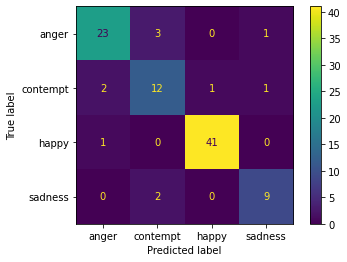

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_confusion_matrix(SDGclass, X_test, y_test_trueSGD)



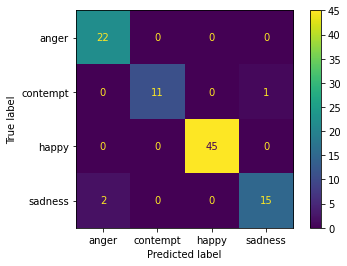

In [23]:
plot_confusion_matrix(SDGclass2, X_test2, y_test_true2SGD)

next SVM

import SVC

In [24]:
from sklearn import svm

fit model and train and compare accuracy


In [25]:

linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [26]:
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)

In [27]:
accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
accuracy_sig = sig.score(X_test, y_test)

print('Accuracy Linear Kernel: ' , accuracy_lin)
print('Accuracy Polynomial Kernel: ', accuracy_poly)
print('Accuracy Radial Basis Kernel: ', accuracy_rbf)
print('Accuracy Sigmoid Kernel: ', accuracy_sig)

Accuracy Linear Kernel:  0.9166666666666666
Accuracy Polynomial Kernel:  0.7395833333333334
Accuracy Radial Basis Kernel:  0.4375
Accuracy Sigmoid Kernel:  0.6770833333333334


do the same for dataset2.csv


In [28]:

linear2 = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train2, y_train2)
rbf2 = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train2, y_train2)
poly2 = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train2, y_train2)
sig2 = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train2, y_train2)

In [29]:
linear_pred2 = linear2.predict(X_test2)
poly_pred2 = poly2.predict(X_test2)
rbf_pred2 = rbf2.predict(X_test2)
sig_pred2 = sig2.predict(X_test2)

In [30]:
accuracy_lin2 = linear2.score(X_test2, y_test2)
accuracy_poly2 = poly2.score(X_test2, y_test2)
accuracy_rbf2 = rbf2.score(X_test2, y_test2)
accuracy_sig2 = sig2.score(X_test2, y_test2)

print('Accuracy Linear Kernel: ' , accuracy_lin2)
print('Accuracy Polynomial Kernel: ', accuracy_poly2)
print('Accuracy Radial Basis Kernel: ', accuracy_rbf2)
print('Accuracy Sigmoid Kernel: ', accuracy_sig2)

Accuracy Linear Kernel:  0.9895833333333334
Accuracy Polynomial Kernel:  0.8229166666666666
Accuracy Radial Basis Kernel:  0.4895833333333333
Accuracy Sigmoid Kernel:  0.6770833333333334


In [31]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

y_test_trueSVM = y_test
y_test_true2SVM = y_test2
#
# y_pred = list()
# y_pred2 = list()
# for a in X_test:
#     y_pred.append(linear.predict(a))
#
# for a in X_test2:
#       y_pred2.append(linear2.predict(a))


In [32]:
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

labels = ['Linear', 'Polynomial', 'Radial Basis', 'Sigmoid']
models = [linear, poly, rbf, sig]


y_predSVM = list()
for label, model in zip(labels, models):
    y_predSVM.append(pd.Series(enc.fit_transform(model.predict(X_test)), name=label))
y_predSVM = pd.concat(y_predSVM, axis=1)
y_testSVM = enc.fit_transform(y_test)

metrics = list()
cm = dict()

for label in labels:

    precision, recall, fscore, _ = score(y_testSVM, y_predSVM[label], average='weighted')

    accuracy = accuracy_score(y_testSVM, y_predSVM[label])

    auc = roc_auc_score(label_binarize(y_testSVM, classes=[0,1,2,3]),
              label_binarize(y_predSVM[label], classes=[0,1,2,3]),
              average='weighted', multi_class='ovr')

    cm[label] = confusion_matrix(y_testSVM, y_predSVM[label])

    metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc }, name=label))

metrics = pd.concat(metrics, axis=1)

metrics


,Linear,Polynomial,Radial Basis,Sigmoid
precision,0.922597,0.773065,0.079102,0.668520
recall,0.916667,0.739583,0.281250,0.677083
fscore,0.917123,0.737802,0.123476,0.664678
accuracy,0.916667,0.739583,0.281250,0.677083
auc,0.949110,0.825186,0.500000,0.788876


In [33]:
labels2 = ['Linear', 'Polynomial', 'Radial Basis', 'Sigmoid']
models2 = [linear2, poly2, rbf2, sig2]

y_pred2SVM = list()

y_test2SVM = enc.fit_transform(y_test2)

for label, model in zip(labels2, models2):
    y_pred2SVM.append(pd.Series(enc.fit_transform(model.predict(X_test2)), name=label))
y_pred2SVM = pd.concat(y_pred2SVM, axis=1)

metrics2 = list()
cm2 = dict()

for label in labels2:

    precision, recall, fscore, _ = score(y_test2SVM, y_pred2SVM[label], average='weighted')

    accuracy = accuracy_score(y_test2SVM, y_pred2SVM[label])

    auc = roc_auc_score(label_binarize(y_test2SVM, classes=[0,1,2]),
              label_binarize(y_pred2SVM[label], classes=[0,1,2]),
              average='weighted', multi_class='ovr')

    cm2[label] = confusion_matrix(y_test2SVM, y_pred2SVM[label])

    metrics2.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc }, name=label))

metrics2 = pd.concat(metrics2, axis=1)

metrics2



,Linear,Polynomial,Radial Basis,Sigmoid
precision,0.990162,0.871441,0.245124,0.719151
recall,0.989583,0.822917,0.145833,0.677083
fscore,0.989506,0.813850,0.066496,0.681670
accuracy,0.989583,0.822917,0.145833,0.677083
auc,0.993671,0.901996,0.514467,0.817616


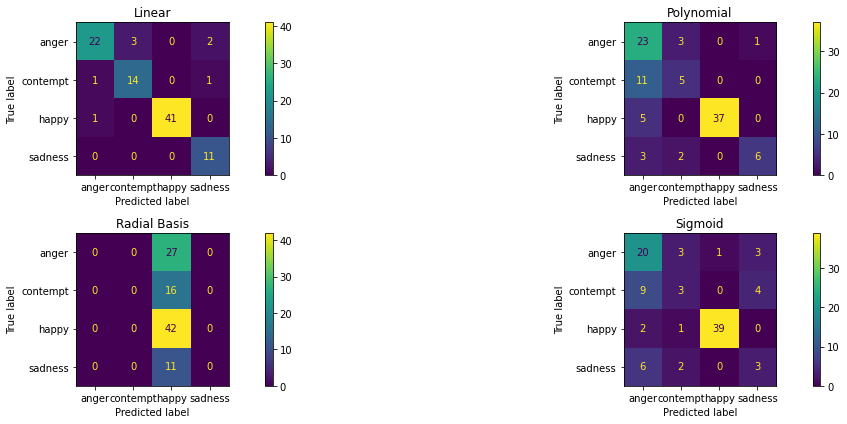

In [34]:
from sklearn import metrics

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(18, 6)

for ax,label,model in zip(axList, labels, models):
    plot_confusion_matrix(model, X_test, y_test_trueSVM, ax=ax)
    ax.set(title=label)

plt.tight_layout()

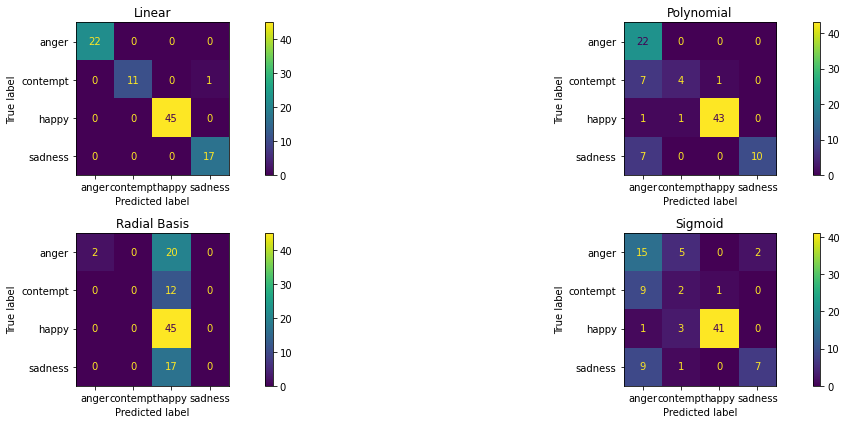

In [35]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(18, 6)

for ax,label,model in zip(axList, labels, models2):
    plot_confusion_matrix(model, X_test2, y_test_true2SVM, ax=ax)
    ax.set(title=label)

plt.tight_layout()

Next we will do a deep learning algorithm, CNN

import the modules and get dataset

In [36]:
import pandas as pd
import numpy as np
import warnings
import cv2
import data
from PIL import Image
import dlib
warnings.filterwarnings("ignore")


import keras for the model training and layers

In [37]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

create the model with it's layers:

In [38]:
input_shape=(48, 48, 1)
num_classes = 4

model_1 = Sequential()
model_1.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model_1.add(Activation('relu'))
model_1.add(Conv2D(32, (5, 5), strides = (1,1)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        25632     
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0

import data generator

In [39]:
from keras.preprocessing.image import ImageDataGenerator


compile the model:

In [40]:
%%time
# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        horizontal_flip=True)
batch_size = 32
opt = RMSprop(lr=0.0005, decay=1e-6)

model_1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_1 = model_1.fit_generator(data_generator.flow(X_trainCNN, y_trainCNN,
                                            batch_size),
                        epochs=20, verbose=1,validation_data =val_data)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
12/12 [==============================] - 1s 113ms/step - loss: 1.3384 - accuracy: 0.4193 - val_loss: 1.2776 - val_accuracy: 0.4479
Epoch 2/20
12/12 [==============================] - 1s 102ms/step - loss: 1.1747 - accuracy: 0.4870 - val_loss: 1.2215 - val_accuracy: 0.5729
Epoch 3/20
12/12 [==============================] - 1s 115ms/step - loss: 1.0973 - accuracy: 0.5339 - val_loss: 0.9782 - val_accuracy: 0.5833
Epoch 4/20
12/12 [==============================] - 1s 101ms/step - loss: 0.9591 - accuracy: 0.5859 - val_loss: 0.7528 - val_accuracy: 0.6667
Epoch 5/20
12/12 [==============================] - 1s 103ms/step - loss: 0.8480 - accuracy: 0.6458 - val_loss: 0.6355 - val_accuracy: 0.7396
Epoch 6/20
12/12 [==============================] - 1s 104ms/step - loss: 0.7485 - accuracy: 0.6901 - val_loss: 0.5567 - val_accuracy: 0.8021
Epoch 7/20
12/12 [==============================] - 1s 105ms/step - loss

Plot

3/3 [==============================] - 0s 18ms/step - loss: 0.2908 - accuracy: 0.8646


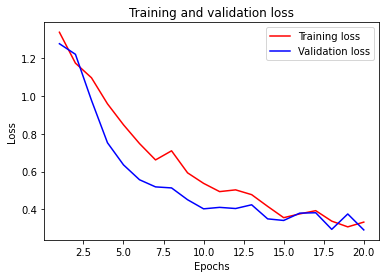

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
score = model_1.evaluate(X_testCNN, y_testCNN, verbose=1)
history_dict=hist_model_1.history
history_dict.keys()

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, train_loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

do the same with dataset2.csv

model:

In [42]:
input_shape=(48, 48, 1)
num_classes = 4

model_2 = Sequential()

model_2.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        832       
_________________________________________________________________
activation_4 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        25632     
_________________________________________________________________
activation_5 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15488)            

data generator

In [43]:
data_generator2 = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        horizontal_flip=True)
batch_size = 32
opt2 = RMSprop(lr=0.0005, decay=1e-6)

model_2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_2 = model_2.fit_generator(data_generator2.flow(X_train2CNN, y_train2CNN,
                                            batch_size),
                        epochs=20, verbose=1,validation_data =val_data2)

Epoch 1/20
12/12 [==============================] - 2s 187ms/step - loss: 1.3882 - accuracy: 0.3750 - val_loss: 1.1403 - val_accuracy: 0.5000
Epoch 2/20
12/12 [==============================] - 2s 169ms/step - loss: 1.1792 - accuracy: 0.5000 - val_loss: 1.0535 - val_accuracy: 0.5312
Epoch 3/20
12/12 [==============================] - 2s 167ms/step - loss: 1.0537 - accuracy: 0.5469 - val_loss: 0.8106 - val_accuracy: 0.7292
Epoch 4/20
12/12 [==============================] - 2s 169ms/step - loss: 0.8872 - accuracy: 0.6562 - val_loss: 0.6165 - val_accuracy: 0.7917
Epoch 5/20
12/12 [==============================] - 2s 166ms/step - loss: 0.7353 - accuracy: 0.7109 - val_loss: 0.5274 - val_accuracy: 0.7500
Epoch 6/20
12/12 [==============================] - 2s 167ms/step - loss: 0.6250 - accuracy: 0.7292 - val_loss: 0.4949 - val_accuracy: 0.8125
Epoch 7/20
12/12 [==============================] - 2s 169ms/step - loss: 0.6319 - accuracy: 0.7344 - val_loss: 0.4047 - val_accuracy: 0.8542
Epoch 

plot

3/3 [==============================] - 0s 9ms/step - loss: 0.1652 - accuracy: 0.9375


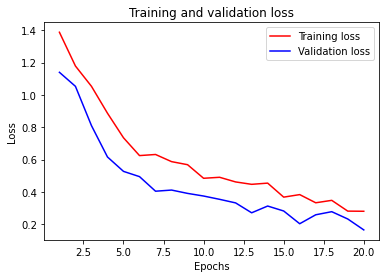

In [44]:
score2 = model_2.evaluate(X_test2CNN, y_test2CNN, verbose=1)
history_dict2=hist_model_2.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'r', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

compare classification metrics


In [45]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

metrics = list()
cm = dict()
y_predCNN = model_1.predict(X_testCNN)
y_pred_class = model_1.predict_classes(X_testCNN, verbose=0)
rounded_labels = np.argmax(y_testCNN, axis=1)

precision, recall, fscore, _ = score(rounded_labels, y_pred_class, average='weighted')
accuracy = accuracy_score(rounded_labels, y_pred_class)
auc = roc_auc_score(y_testCNN, y_predCNN)
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'AUC':auc}, name="model1"))
cm = confusion_matrix(rounded_labels,y_pred_class)

metrics2 = list()
cm2 = dict()
y_pred2CNN = model_2.predict(X_test2CNN)
y_pred_class2 = model_2.predict_classes(X_test2CNN, verbose=0)
rounded_labels2 = np.argmax(y_test2CNN, axis=1)

precision2, recall2, fscore2, _ = score(rounded_labels2, y_pred_class2, average='weighted')
accuracy2 = accuracy_score(rounded_labels2, y_pred_class2)
auc2 = roc_auc_score(y_test2CNN, y_pred2CNN)
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2, 'AUC':auc2}, name="model2"))
cm2 = confusion_matrix(rounded_labels2,y_pred_class2)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,model1,model2
precision,0.875543,0.943750
recall,0.864583,0.937500
fscore,0.867037,0.937379
accuracy,0.864583,0.937500
AUC,0.978105,0.995490


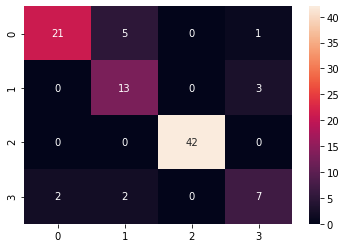

In [46]:

ax = sns.heatmap(cm, annot=True, fmt='d')



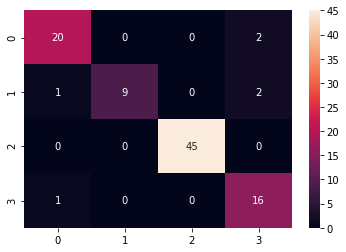

In [47]:

ax2 = sns.heatmap(cm2, annot=True, fmt='d')

In [48]:

m_new = metrics
mKNN = metricsKNN


In [49]:
df = pd.concat([m_new, mKNN], axis=1, ignore_index=True)
df.rename(columns={0: "model 1 CNN", 1: "model 2 CNN", 2:'model 1 KN', 3 : 'model 2 KNN'})

,model 1 CNN,model 2 CNN,model 1 KN,model 2 KNN
precision,0.875543,0.943750,0.678905,0.704633
recall,0.864583,0.937500,0.666667,0.687500
fscore,0.867037,0.937379,0.671121,0.691660
accuracy,0.864583,0.937500,0.666667,0.687500
AUC,0.978105,0.995490,0.787383,0.793750
